# Random Forest Classifier

## Get dataset

In [2]:
import finlab.ml as ml

dataset = ml.fundamental_features()

print(dataset.shape)
dataset = dataset.dropna(thresh=int(len(dataset)*0.5), axis=1).dropna(how='any')
print(dataset.shape)

(62667, 49)
(18003, 49)


## Add labels

In [3]:
feature_names = list(dataset.columns)

In [4]:
ml.add_profit_prediction(dataset)
dataset.head()

T3395營業利益  T7210營運現金流  T3950歸屬母公司淨利    T7211折舊  \
stock_id date                                                         
1101     2014-05-15  3684224.0   6895832.0     4015175.0  1594505.0   
         2014-08-14  5938317.0   4452573.0     -754894.0  1573692.0   
         2014-11-14  5544164.0   3701961.0     3621052.0  1587492.0   
         2015-03-31  4690964.0   4936554.0     6459366.0  1575810.0   
         2015-05-15  1693508.0   5654152.0      349121.0  1711428.0   

                      T0100流動資產   T1100流動負債  T7324取得不動產廠房及設備  T3970經常稅後淨利  \
stock_id date                                                               
1101     2014-05-15  92121458.0  74388787.0        -940633.0    2791235.0   
         2014-08-14  89163129.0  81190613.0        -465009.0    4828695.0   
         2014-11-14  89472928.0  78920574.0        -911057.0    4934486.0   
         2015-03-31  96605816.0  68632044.0       -1384489.0    4029460.0   
         2015-05-15  92471096.0  69579858.0        -818460.0     974518.0   

                     R101_ROA稅後息前  R11V_ROA綜合損益  ...   R501_流動比率   R502_速動比率  \
stock_id date                                    ...                           
1101     2014-05-15     -1.732411      1.630076  ...  123.837828  101.776758   
         2014-08-14     -0.952778      0.152556  ...  109.819505   91.450337   
         2014-11-14     -0.948101      2.168353  ...  113.370853   93.976558   
         2015-03-31     -1.265106      3.002608  ...  140.759054  117.966121   
         2015-05-15     -2.315297      0.069454  ...  132.899231  109.303861   

                     R503_利息支出率   R678_營運資金  R607_總資產週轉次數  R610_存貨週轉率  \
stock_id date                                                           
1101     2014-05-15   -9.792979  17732671.0      0.023981    0.550675   
         2014-08-14  -17.435186   7972516.0      0.028432    0.622629   
         2014-11-14  -17.800651  10552354.0      0.026593    0.581786   
         2015-03-31  -13.169666  27973772.0      0.025961    0.565798   
         2015-05-15   -7.153186  22891238.0      0.018713    0.455819   

                     R612_固定資產週轉次數  R613_淨值週轉率次  R69B_自由現金流量    return  
stock_id date                                                           
1101     2014-05-15    -81394854.0     0.044805    4901868.0  1.073347  
         2014-08-14    -74379365.0     0.052721   16542181.0  0.984816  
         2014-11-14    -76877637.0     0.049112    4768224.0  0.969163  
         2015-03-31    -78804395.0     0.047718  -10525322.0  0.956818  
         2015-05-15    -89211708.0     0.034296    8494249.0  0.850077  

[5 rows x 50 columns]

## Split Train Test dataset

In [5]:
date_arr = dataset.index.get_level_values('date') < '2017'
dataset_train = dataset[date_arr]
dataset_test = dataset[~date_arr]

## Training

### RandomForest

In [6]:
from sklearn.ensemble import RandomForestClassifier

cf = RandomForestClassifier(n_estimators=100)

train = dataset_train[feature_names] , dataset_train['return'] > 1 
test = dataset_test[feature_names] , dataset_test['return'] > 1 

cf.fit(*train)
cf.score(*test)
cf.predict(test[0])

array([ True,  True,  True, ...,  True, False, False])

### Xgboost

In [10]:
import xgboost
cf_xgb = xgboost.XGBClassifier()
cf_xgb.fit(*train)
cf_xgb.score(*test)

0.5349731754226136

### lightgbm

In [14]:
import lightgbm
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

fit_params={"early_stopping_rounds":30, 
            "eval_metric" : 'auc', 
            "eval_set" : [test],
            'eval_names': ['valid'],
            'verbose': 100,
            'categorical_feature': 'auto'}

param_test ={'num_leaves': sp_randint(6, 50), 
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

#This parameter defines the number of HP points to be tested
n_HP_points_to_test = 100

#n_estimators is set to a "large value". The actual number of trees build will depend on early stopping and 5000 define only the absolute maximum
clf = lgb.LGBMClassifier(max_depth=-1, random_state=314, silent=True, metric='None', n_jobs=4, n_estimators=5000)
gs = RandomizedSearchCV(
    estimator=clf, param_distributions=param_test, 
    n_iter=n_HP_points_to_test,
    scoring='roc_auc',
    cv=3,
    refit=True,
    random_state=314,
    verbose=True)

gs.fit(*train, **fit_params)



Fitting 3 folds for each of 100 candidates, totalling 300 fits
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[18]	valid's auc: 0.556853


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[28]	valid's auc: 0.556306
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[23]	valid's auc: 0.555824
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[20]	valid's auc: 0.556724
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[28]	valid's auc: 0.557119
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[16]	valid's auc: 0.561241
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation 

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   42.2s finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=LGBMClassifier(boosting_type='gbdt',
                                            class_weight=None,
                                            colsample_bytree=1.0,
                                            importance_type='split',
                                            learning_rate=0.1, max_depth=-1,
                                            metric='None', min_child_samples=20,
                                            min_child_weight=0.001,
                                            min_split_gain=0.0,
                                            n_estimators=5000, n_jobs=4,
                                            num_leaves=31, objective=None,
                                            random_state=314, reg_...
                                                             100.0, 1000.0,
                                                             10000.0],
                       

In [15]:

cf_lgbm = lightgbm.LGBMClassifier(boosting_type='gbdt', class_weight=None,
        colsample_bytree=0.7792703648870174, importance_type='split',
        learning_rate=0.1, max_depth=-1, metric='None',
        min_child_samples=344, min_child_weight=0.01, min_split_gain=0.0,
        n_estimators=5000, n_jobs=4, num_leaves=10, objective=None,
        random_state=314, reg_alpha=0, reg_lambda=10, silent=True,
        subsample=0.8503048560728566, subsample_for_bin=200000,
        subsample_freq=0)

cf_lgbm.fit(dataset_train[feature_names],dataset_train['return'] > 1, **fit_params)
cf_lgbm.score(dataset_test[feature_names],dataset_test['return'] > 1)

Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[16]	valid's auc: 0.565369


0.5565157276183892

## Prediction

In [18]:
prediction = gs.predict_proba(test[0])
#prediction = cf_lgbm.predict_proba(test[0])

prediction = prediction.swapaxes(0,1)[1]
prediction

array([0.50826013, 0.49973632, 0.50826013, ..., 0.47550883, 0.48666841,
       0.47263457])

## Backtest

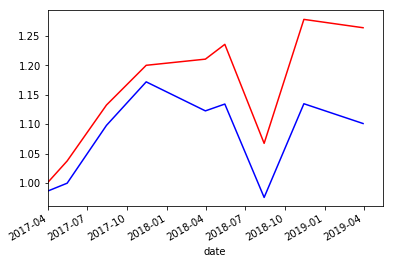

In [19]:
%matplotlib inline
returns = dataset_test['return'][prediction > 0.5]
dates = returns.index.get_level_values("date")
returns.groupby(dates).mean().cumprod().plot(color='red')

returns = dataset_test['return'][prediction < 0.5]
dates = returns.index.get_level_values("date")
returns.groupby(dates).mean().cumprod().plot(color='blue')